In [1]:
import numpy as np
from numpy.typing import ArrayLike
dataset = "mushrooms.txt" 
from lovely_numpy import lo
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.datasets import load_svmlight_file
from typing import List
from sklearn.model_selection import train_test_split


data = load_svmlight_file(dataset)
D, b = data[0].toarray(), data[1]
b = 2 * b - 3

D_train, D_val, b_train, b_val = train_test_split(D, b, test_size=0.25)

In [2]:
def quantize_vector(v: ArrayLike, K) -> ArrayLike:
    # randK quantization of the vector
    # K - number of nonzero vector elements after the quantization
    to_erase = len(v) - K
    rand_indeces = np.random.choice(len(v), size=to_erase, replace=False)
    v_q = v.copy()
    v_q[rand_indeces] = 0
    return v_q

def quantize_vector_robust(v: ArrayLike, ids) -> ArrayLike:
    v_q = v.copy()
    v_q[ids] = 0
    return v_q

def calculate_loss(DX: ArrayLike, b: ArrayLike) -> np.float32:
    # ||DX - b||_2^2
    return np.linalg.norm(DX - b) ** 2


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def accuracy_score(D, X, b):
    vals = D @ X
    # preds = sigmoid(vals)
    preds = [-1 if val < 0 else 1 for val in vals]
    return np.sum(preds == b) / len(b)

In [3]:
class ClientServer:
    def __init__(self, d_i: ArrayLike, gamma=5e-4) -> None:
        self.d = d_i
        self.x = np.random.random()
        self.f = None
        self.gamma = gamma
        self.grad = None

    # calculate target function on the client feature
    # f_i = d_i * x_i
    def calculate_local_function(self) -> ArrayLike:
        f_i = self.d * self.x
        self.f = f_i

    def calculate_quantized_local_function(self, K) -> ArrayLike:
        f_i = self.d * self.x
        self.f = quantize_vector(f_i, K)

    def calculate_quantized_local_function_robust(self, ids) -> ArrayLike:
        self.f = self.d * self.x
        return quantize_vector_robust(self.f, ids)

    def loss_gradient(self, error_vector: ArrayLike) -> np.float32:
        # error vector = DX - b
        # dL/(dx_i) = 2d_i^T(DX - b)
        dL = 2 * self.d.T @ error_vector
        self.grad = dL

    def gradient_step(self):
        # x^{k+1} = x - 2gamma*d_i^T(DX - b)
        # error_vector = DX - b
        self.x = self.x - self.gamma * self.grad
        self.grad = None

In [4]:
# Calculating DX = sum(d_i * x_i) for all clients
def client_values_aggregation(clients: List) -> ArrayLike:
    # dx_values - vector of dx values from all clients (matrix)
    # return - aggregation of all dx values (sum)
    dx_values = np.array(list(map(lambda x: x.f, clients)))
    return np.sum(dx_values, axis=0)  # DX

# collect x_i from all clients
def construct_full_vector(clients: List[ClientServer]):
    X = []
    for client in clients:
        X.append(client.x)
    return np.array(X)

In [5]:
Hessian = 2 * D.T @ D
L = np.max(np.linalg.eigvalsh(Hessian))

In [6]:
def gradient_step(clients: List[ClientServer], D, b, K, single_rseed=True):
    erase_ids = np.random.choice(D.shape[0], size=D.shape[0] - K, replace=False)
    local_function_values = []
    for client in clients:
        if not single_rseed:
            erase_ids = np.random.choice(D.shape[0], size=D.shape[0] - K, replace=False)
        f_i = client.calculate_quantized_local_function_robust(erase_ids)
        local_function_values.append(f_i)
    DX = np.sum(local_function_values, axis=0)
    if not single_rseed:
        erase_ids = np.random.choice(D.shape[0], size=D.shape[0] - K, replace=False)
    # b_q = quantize_vector_robust(b, erase_ids)
    error_vector = DX - b
    error_vector = quantize_vector_robust(error_vector, erase_ids)
    grad_norm = 0
    for client in clients:
        client.loss_gradient(error_vector)
        grad_norm += np.abs(client.grad)
        client.gradient_step()
        client.calculate_local_function()
    return grad_norm

In [7]:
def run_experiment(num_iters, K, D, b, single_rseed=True):
    feature_clients = []
    for feature in D.T:
        client = ClientServer(feature, gamma=1.5/L)
        client.calculate_local_function()
        feature_clients.append(client)

    iters = range(num_iters)
    loss_hist = []
    grad_hist = []
    progress = tqdm(iters)
    for i in progress:
        grad_norm = gradient_step(feature_clients, D, b, K, single_rseed)
        if i == 0:
            init_gradnorm = grad_norm

        
        X = construct_full_vector(feature_clients)
        loss = np.linalg.norm(D @ X - b) ** 2
        progress.set_description(f"Loss: {loss:.3e}, Grad Norm: {grad_norm / init_gradnorm:.3e}") 
        loss_hist.append(loss)
        grad_hist.append(grad_norm / init_gradnorm)

    X = construct_full_vector(feature_clients)
    acc_train = accuracy_score(D, X, b)
    print(acc_train)
    return loss_hist, grad_hist, X

Loss: 5.287e+05, Grad Norm: 1.052e+00:   0%|          | 4/1000 [00:00<00:26, 37.55it/s]

Loss: 3.914e+05, Grad Norm: 8.617e-01: 100%|██████████| 1000/1000 [00:28<00:00, 35.38it/s]


0.5214180206794683
Accuracy on train set With K = 100: 0.521
Accuracy on val set With K = 100: 0.5076317085179715


Loss: 1.171e+05, Grad Norm: 5.551e-02: 100%|██████████| 1000/1000 [00:27<00:00, 36.39it/s]


0.9686525521089775
Accuracy on train set With K = 1000: 0.969
Accuracy on val set With K = 1000: 0.9675036927621861


Loss: 2.226e+04, Grad Norm: 1.036e-02: 100%|██████████| 1000/1000 [00:27<00:00, 36.15it/s]


0.9786640407024454
Accuracy on train set With K = 2000: 0.979
Accuracy on val set With K = 2000: 0.9817823732151649


Loss: 1.268e+02, Grad Norm: 3.558e-04: 100%|██████████| 1000/1000 [00:26<00:00, 37.35it/s]


0.9981946495978993
Accuracy on train set without Quantization: 0.998
Accuracy on val set  without Quantization: 0.9985228951255539


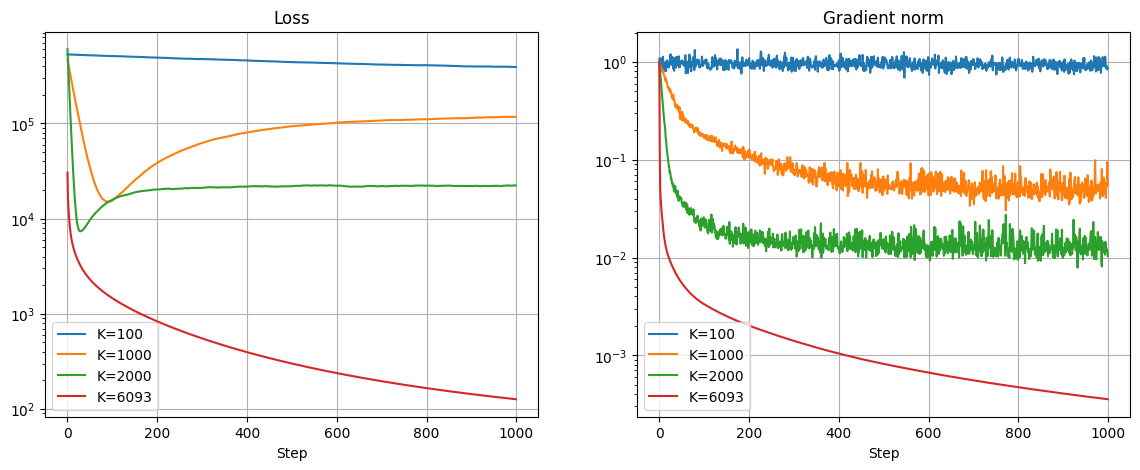

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].grid()
axes[0].set_title("Loss")
axes[0].set_xlabel('Step')
axes[1].grid()
axes[1].set_title("Gradient norm")
axes[1].set_xlabel('Step')

Ks = [100, 1000, 2000, D_train.shape[0]]
for k in Ks:
    q = True
    if k == D_train.shape[0]:
        q = False
    loss_history, grad_norm_history, X = run_experiment(1000, k, D_train, b_train, single_rseed=False) 
    label = f'K={k}'
    if k == q:
        label = 'No quant'
    axes[0].plot(loss_history, label=label)
    axes[1].plot(grad_norm_history, label=label)
    acc_train = accuracy_score(D_train, X, b_train)
    acc_val = accuracy_score(D_val, X, b_val)
    if k != D_train.shape[0]:
        print(f"Accuracy on train set With K = {k}: {acc_train:.3f}")
        print(f"Accuracy on val set With K = {k}: {acc_val}")
    else:
        print(f"Accuracy on train set without Quantization: {acc_train:.3f}")
        print(f"Accuracy on val set  without Quantization: {acc_val}")       
    print('='*75)

axes[0].set_yscale('log')
axes[1].set_yscale('log')
axes[0].legend()
axes[1].legend()
plt.show()

Loss: 5.820e+05, Grad Norm: 9.933e-01:   0%|          | 0/1000 [00:00<?, ?it/s]

Loss: 4.570e+03, Grad Norm: 1.502e-02: 100%|██████████| 1000/1000 [00:14<00:00, 67.99it/s]


0.8445757426555063
Accuracy on train set With K = 100: 0.845
Accuracy on val set With K = 100: 0.8468734613490891


Loss: 1.033e+03, Grad Norm: 2.527e-03: 100%|██████████| 1000/1000 [00:15<00:00, 65.52it/s]


0.96602658788774
Accuracy on train set With K = 1000: 0.966
Accuracy on val set With K = 1000: 0.9675036927621861


Loss: 4.603e+02, Grad Norm: 1.659e-03: 100%|██████████| 1000/1000 [00:13<00:00, 71.49it/s]


0.9845724602002298
Accuracy on train set With K = 2000: 0.985
Accuracy on val set With K = 2000: 0.982767109798129


Loss: 1.542e+02, Grad Norm: 4.803e-04: 100%|██████████| 1000/1000 [00:13<00:00, 75.17it/s]


0.999015263417036
Accuracy on train set without Quantization: 0.999
Accuracy on val set  without Quantization: 0.9980305268340719


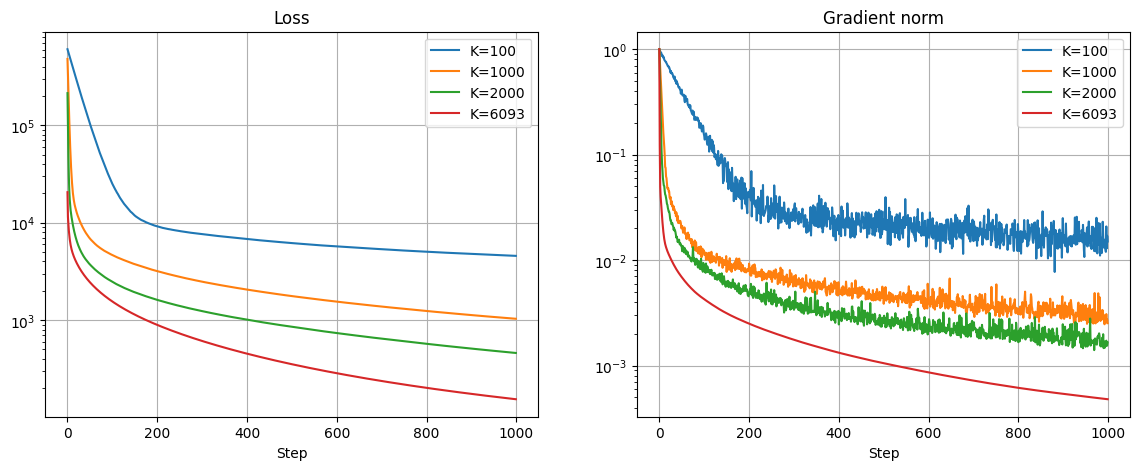

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].grid()
axes[0].set_title("Loss")
axes[0].set_xlabel('Step')
axes[1].grid()
axes[1].set_title("Gradient norm")
axes[1].set_xlabel('Step')

Ks = [100, 1000, 2000, D_train.shape[0]]
for k in Ks:
    q = True
    if k == D_train.shape[0]:
        q = False
    loss_history, grad_norm_history, X = run_experiment(1000, k, D_train, b_train, single_rseed=True) 
    label = f'K={k}'
    if k == q:
        label = 'No quant'
    axes[0].plot(loss_history, label=label)
    axes[1].plot(grad_norm_history, label=label)
    acc_train = accuracy_score(D_train, X, b_train)
    acc_val = accuracy_score(D_val, X, b_val)
    if k != D_train.shape[0]:
        print(f"Accuracy on train set With K = {k}: {acc_train:.3f}")
        print(f"Accuracy on val set With K = {k}: {acc_val}")
    else:
        print(f"Accuracy on train set without Quantization: {acc_train:.3f}")
        print(f"Accuracy on val set  without Quantization: {acc_val}")       
    print('='*75)

axes[0].set_yscale('log')
axes[1].set_yscale('log')
axes[0].legend()
axes[1].legend()
plt.show()